# Data Loading

In [40]:
#Imports
import pandas as pd
import json

#Load Data
business_df = pd.read_json('../yelp_data/yelp_academic_dataset_business.json', lines=True)

#Filter by category (Food and restaurants)
#notes to self: fillna for replacing all missing values (NaNs)
restaurants_df = business_df[business_df['categories'].fillna('').str.contains('Restaurants|Food', case=False, na=False)]
# city_counts = business_df['city'].value_counts().head(20)
# print(city_counts)
restaurants_sample = restaurants_df.sample(n=5000, random_state=42)
print(f"Filtered to {len(restaurants_sample)} food-related businesses")

print(restaurants_sample.head())

Filtered to 5000 food-related businesses
                   business_id                     name  \
86838   rur-gWxPITnyKn9F2lsOvQ        Giant Food Stores   
130099  cX2CcTc_KNE_BinmXALBwA   Prime Time Bar & Grill   
99702   RwsLzLhCzGX2BcIM5BiwCQ  La Michoacana Premium 2   
82484   ZtjQub4hsEbltiofZyllRA   Moju's Family Pizzeria   
88041   rYTdFa_sH5eE41wfg9LMhA                Starbucks   

                       address          city state postal_code   latitude  \
86838         3477 Lincoln Hwy     Thorndale    PA       19372  39.996351   
130099       11408 US Hwy 19 N   Port Richey    FL       34668  28.323101   
99702   2651 Murfreesboro Pike     Nashville    TN       37217  36.072960   
82484   2501 E Westmoreland St  Philadelphia    PA       19134  39.988325   
88041         10015 Gravois Rd        Affton    MO       63123  38.551156   

        longitude  stars  review_count  is_open  \
86838  -75.754664    2.0            19        1   
130099 -82.698415    2.5             5 

# Load and Join Reviews

In [41]:
# Get business_ids from sampled restaurants/food establishments
sample_ids = set(restaurants_sample['business_id'])

# Load only reviews for the sampled restaurants/food establishments
reviews_sample = pd.read_json('../yelp_data/yelp_academic_dataset_review.json', lines=True, chunksize=100000)

filtered_reviews = pd.concat([
    chunk[chunk['business_id'].isin(sample_ids)]
    for chunk in reviews_sample
])
print(f"Filtered to {len(filtered_reviews)} business-related reviews")
print(filtered_reviews.head())

Filtered to 394935 business-related reviews
                 review_id                 user_id             business_id  \
7   _ZeMknuYdlQcUqng_Im3yg  yfFzsLmaWF2d4Sr0UNbBgg  LHSTtnW3YHCeUkRDGyJOyw   
40  mO398Ed5dpv1H5ZsKc8KXw  yobeeTUBfaTBcnk26mXNuA  hKameFsaXh9g8WQbv593UA   
50  yCbzm_d4cHpfUX00Ljvgmg  bHSoye7R5cL-LVWLxtaxMg  SSZDGl2J-CEyIzuIbEiYNQ   
51  r2IBPY_E8AE5_GpsqlONyg  IKbjLnfBQtEyVzEu8CuOLg  VJEzpfLs_Jnzgqh5A_FVTg   
67  Ad91EzbAGRCR1SwkPfZJKg  LWTvg7RlyNLXIf482tXBPw  WCVFqK84i2H5EClSoow7ZA   

    stars  useful  funny  cool  \
7       5       2      0     0   
40      4       0      0     0   
50      2       2      0     0   
51      4       0      0     0   
67      5       0      0     0   

                                                 text                date  
7   Amazingly amazing wings and homemade bleu chee... 2015-08-07 02:29:16  
40  Food was good- atmosphere/decor is like a fish... 2015-04-15 15:30:48  
50  We started with the artichoke dip, big mistake... 

# Add User Ratings

In [42]:
#get unique user ids from the filtered reviews
user_ids = set(filtered_reviews['user_id'].unique())
print(f"Number of unique users: {len(user_ids)}")

#read and filter users
chunks = pd.read_json('../yelp_data/yelp_academic_dataset_user.json', lines=True, chunksize=100000)
matched_users = pd.concat([
    chunk[chunk['user_id'].isin(user_ids)][['user_id','average_stars','review_count']]
    for chunk in chunks
])

#merge into review data
print(f"Matched {len(matched_users)} users from user data")
reviews_with_user = filtered_reviews.merge(
    matched_users,
    on='user_id',
    how='left'
)

print(reviews_with_user.head())

Number of unique users: 256898
Matched 256897 users from user data
                review_id                 user_id             business_id  \
0  _ZeMknuYdlQcUqng_Im3yg  yfFzsLmaWF2d4Sr0UNbBgg  LHSTtnW3YHCeUkRDGyJOyw   
1  mO398Ed5dpv1H5ZsKc8KXw  yobeeTUBfaTBcnk26mXNuA  hKameFsaXh9g8WQbv593UA   
2  yCbzm_d4cHpfUX00Ljvgmg  bHSoye7R5cL-LVWLxtaxMg  SSZDGl2J-CEyIzuIbEiYNQ   
3  r2IBPY_E8AE5_GpsqlONyg  IKbjLnfBQtEyVzEu8CuOLg  VJEzpfLs_Jnzgqh5A_FVTg   
4  Ad91EzbAGRCR1SwkPfZJKg  LWTvg7RlyNLXIf482tXBPw  WCVFqK84i2H5EClSoow7ZA   

   stars  useful  funny  cool  \
0      5       2      0     0   
1      4       0      0     0   
2      2       2      0     0   
3      4       0      0     0   
4      5       0      0     0   

                                                text                date  \
0  Amazingly amazing wings and homemade bleu chee... 2015-08-07 02:29:16   
1  Food was good- atmosphere/decor is like a fish... 2015-04-15 15:30:48   
2  We started with the artichoke dip, big m

# Adjust Rating Calculation for Bias
Some users tend to rate more harshly or more generously than others, this is to attempt to "normalize" user bias based on their average ratings. Although in this dataset, this is not a prevelant issue since it is centered around US based reviews, if it were a global review data this is good to factor in cultural differences. For example, in Japan, Google average review ratings are much lower and a 3 star rating is equivalent to around a 4.5-5 star here.

In [43]:
def adjustRating(row):
    #only adjusting for users with a substantial amount of reviews to base off of
    if pd.notnull(row['average_stars']) and pd.notnull(row['review_count']) and row['review_count'] >= 15:
        diff = row['stars'] - row['average_stars']
        return max(1.0, min(5.0, 3.0 + diff)) #3.0 is a neutral midpoint baseline
    return row['stars']
reviews_with_user['adjusted_rating'] = reviews_with_user.apply(adjustRating, axis=1)

In [49]:
#compare original and adjusted mean ratings
print("Original mean star rating:", reviews_with_user['stars'].mean())
print("Bias-adjusted mean rating:", reviews_with_user['adjusted_rating'].mean())

#change stars to the normalized ratings
adjusted_business_stats = reviews_with_user.groupby('business_id').agg(
    adjusted_mean=('adjusted_rating', 'mean'),
    original_mean=('stars', 'mean'),
    total_reviews=('stars', 'count')
).reset_index()

restaurants_sample = restaurants_sample.merge(adjusted_business_stats, on='business_id', how='left')
print(restaurants_sample['adjusted_mean'].head())

Original mean star rating: 3.7893830630356895
Bias-adjusted mean rating: 3.265673541215642
0    1.832000
1    2.382000
2    4.056667
3    3.876765
4    2.561333
Name: adjusted_mean, dtype: float64


# Recalculate Restaurant Ratings

In [ ]:
# Recalculate Restaurant Ratings using Adjusted Ratings
# Get the average adjusted rating and adjusted review count per restaurant
adjusted_business_stats = reviews_with_user.groupby('business_id').agg(
    adjusted_avg_rating=('adjusted_rating', 'mean'),
    adjusted_review_count=('adjusted_rating', 'count')
).reset_index()

# Merge the recalculated stats back into the restaurant metadata
restaurants_sample = restaurants_sample.drop(
    columns=['adjusted_avg_rating', 'adjusted_review_count'], errors='ignore'
).merge(
    adjusted_business_stats,
    on='business_id',
    how='left'
)


# Compare original vs adjusted ratings
print(restaurants_sample[['name', 'stars', 'adjusted_avg_rating', 'review_count', 'adjusted_review_count']].head())
print(f"restaurants with reviews and users: {len(restaurants_df)}")


                      name  stars  adjusted_avg_rating  review_count  \
0        Giant Food Stores    2.0             1.832000            19   
1   Prime Time Bar & Grill    2.5             2.382000             5   
2  La Michoacana Premium 2    4.5             4.056667             9   
3   Moju's Family Pizzeria    4.0             3.876765            59   
4                Starbucks    3.0             2.561333            14   

   adjusted_review_count  
0                     20  
1                      5  
2                      9  
3                     68  
4                     15  
restaurants with reviews: 64616


# Visualize Rating Distributions

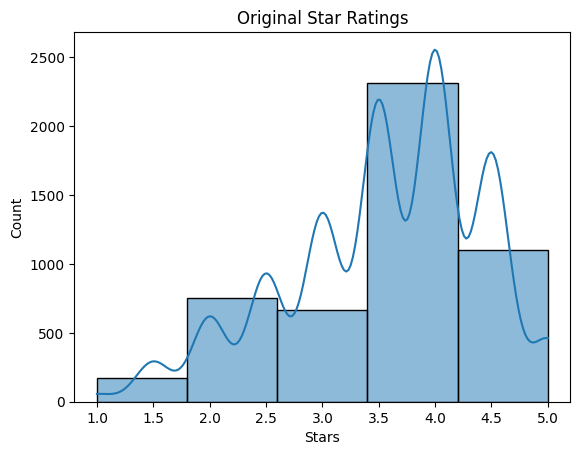

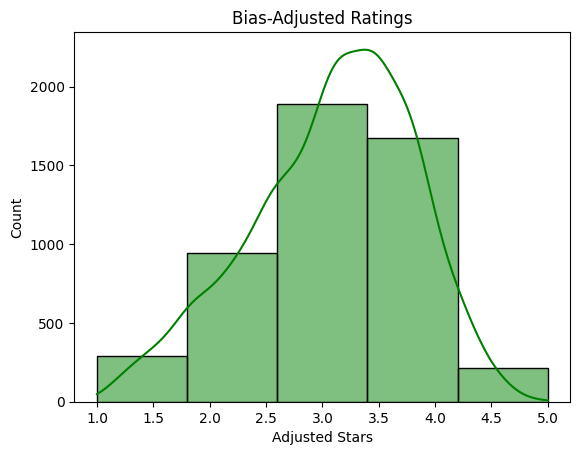

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Original star ratings
sns.histplot(restaurants_sample['stars'], bins=5, kde=True)
plt.title("Original Star Ratings")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.show()

# Bias-adjusted ratings
sns.histplot(restaurants_sample['adjusted_avg_rating'], bins=5, kde=True, color='green')
plt.title("Bias-Adjusted Ratings")
plt.xlabel("Adjusted Stars")
plt.ylabel("Count")
plt.show()


# Map Star Ratings to Sentiment Labels

In [60]:
def star_to_sentiment(stars):
    if stars <= 2:
        return 'negative'
    elif 2 < stars < 4:
        return 'neutral'
    else:
        return 'positive'

reviews_with_user['sentiment'] = reviews_with_user['adjusted_rating'].apply(star_to_sentiment)
print(reviews_with_user.head())

                review_id                 user_id             business_id  \
0  _ZeMknuYdlQcUqng_Im3yg  yfFzsLmaWF2d4Sr0UNbBgg  LHSTtnW3YHCeUkRDGyJOyw   
1  mO398Ed5dpv1H5ZsKc8KXw  yobeeTUBfaTBcnk26mXNuA  hKameFsaXh9g8WQbv593UA   
2  yCbzm_d4cHpfUX00Ljvgmg  bHSoye7R5cL-LVWLxtaxMg  SSZDGl2J-CEyIzuIbEiYNQ   
3  r2IBPY_E8AE5_GpsqlONyg  IKbjLnfBQtEyVzEu8CuOLg  VJEzpfLs_Jnzgqh5A_FVTg   
4  Ad91EzbAGRCR1SwkPfZJKg  LWTvg7RlyNLXIf482tXBPw  WCVFqK84i2H5EClSoow7ZA   

   stars  useful  funny  cool  \
0      5       2      0     0   
1      4       0      0     0   
2      2       2      0     0   
3      4       0      0     0   
4      5       0      0     0   

                                                text                date  \
0  Amazingly amazing wings and homemade bleu chee... 2015-08-07 02:29:16   
1  Food was good- atmosphere/decor is like a fish... 2015-04-15 15:30:48   
2  We started with the artichoke dip, big mistake... 2017-09-08 23:20:19   
3  It was my fiance's birthday and